In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## The initial library
Below the initial library (previous one with new functionnalities), you can look at it if you want to now how it works but it is not necessary yet.
Some operation are implemented :
* Addition if x is a node you can add using `x + k` (notice that k is not necessarilly a node)
* Multiplication (or hadamard product) using `x * y`
* Selection using `x[i, :]` (same syntax as numpy) you also canset value in the node using `x[i, j] = value` (where x and value are nodes) Notice that this last functionalitie create a new derivate node at each selection/attribution
* Sum using x.sum() (with axis eventually)
* Average using x.mean()
* ...

NB : !!! It is clearly not an efficient implementation !!!

In [2]:
class Operation(object):
    @staticmethod
    def forward(*args):
        raise NotImplementedError("It is an abstract method")
    
    def __call__(self, *args):
        output_node = self.forward(*args)
        output_node.set_func(self)
        return output_node
        
    @staticmethod
    def backward(*args):
        pass
class Addition(Operation):
    @staticmethod
    def forward(x, y):
        output_array = x.value + y.value
        output_node = ComputationGraphNode(output_array)
        output_node.set_input_nodes(x, y)
        return output_node

    @staticmethod
    def backward(x, y, gradient):
        return (gradient, gradient)

class Selection(Operation):
    @staticmethod
    def forward(x, slice):
        np_x = x.value

        output_array = np_x.__getitem__(slice)
        
        output_node = ComputationGraphNode(output_array)
        output_node.set_input_nodes(x)
        output_node.set_func_parameters(slice)

        return output_node
        
    @staticmethod
    def backward(x, slice, gradient):
        np_x = x.value

        cgrad = np_x.copy()
        cgrad.fill(0)
        cgrad.__setitem__(slice, gradient)
        
        return cgrad,

class Multiplication(Operation):
    @staticmethod
    def forward(x, y):
        np_x = x.value
        np_y = y.value

        output_array = np_x * np_y 
        
        output_node = ComputationGraphNode(output_array)
        output_node.set_input_nodes(x, y)

        return output_node
        
    @staticmethod
    def backward(x, y, gradient):
        np_x = x.value
        np_y = y.value
        return (np_y * gradient, np_x * gradient) 
        
class Sum(Operation):
    @staticmethod
    def forward(x, axis):
        np_x = x.value

        output_array = np.sum(np_x, axis=axis)
        
        output_node = ComputationGraphNode(output_array)
        output_node.set_input_nodes(x)
        output_node.set_func_parameters(axis)

        return output_node
        
    @staticmethod
    def backward(x, axis, gradient):
        np_g = np.ones(x.value.shape)
        
        return np_g * gradient, 

class Mean(Operation):
    @staticmethod
    def forward(x, axis):
        np_x = x.value

        output_array = np.mean(np_x, axis=axis)
        output_node = ComputationGraphNode(output_array)
        output_node.set_input_nodes(x)
        output_node.set_func_parameters(axis)

        return output_node
        
    @staticmethod
    def backward(x, axis, gradient):
        np_g = np.ones(x.value.shape)
        divider = np.prod(np_g.shape)
        if axis is not None:
            divider = np_g.shape[axis]
        
        return (np_g/divider) * gradient, 

class Max(Operation):
    @staticmethod
    def forward(x, axis):
        np_x = x.value

        output_array = np.max(np_x, axis=axis)
        
        output_node = ComputationGraphNode(output_array)
        output_node.set_input_nodes(x)
        output_node.set_func_parameters(axis)

        return output_node
        
    @staticmethod
    def backward(x, axis, gradient):
        np_g = np.zeros(x.value.shape)
        np_g[np.argmax(np_g, axis=axis)] = 1.
        
        return np_g * gradient,    

class Pad(Operation):
    @staticmethod
    def forward(x, where):
        np_x = x.value

        output_array = np.pad(np_x, where)
        
        output_node = ComputationGraphNode(output_array)
        output_node.set_input_nodes(x)
        output_node.set_func_parameters(where)
        return output_node
        
    @staticmethod
    def backward(x, where, gradient):
        np_g = np.ones(x.value.shape)
        def unpad(x, pad_width):
            slices = []
            for c in pad_width:
                e = None if c[1] == 0 else -c[1]
                slices.append(slice(c[0], e))
            return x[tuple(slices)]
        return np_g * unpad(gradient, where),    

class SetSelection(Operation):
    @staticmethod
    def forward(x, slice, value):
        np_x = np.copy(x.value)
        if value.value.ndim == 1 and value.value.shape[0] == 1:
            np_x.__setitem__(slice, value.value[0])
        else:
            np_x.__setitem__(slice, value.value)
        output_array = np_x
        
        output_node = ComputationGraphNode(output_array)
        output_node.set_input_nodes(x, value)
        output_node.set_func_parameters(slice)
        return output_node
        
    @staticmethod
    def backward(x, value, slice, gradient):
        np_x = x.value
        np_value = np.ones(value.value.shape)
        cgrad = np_x.copy()
        cgrad.fill(1)
        cgrad.__setitem__(slice, gradient.__getitem__(slice))
        return cgrad, np_value * gradient.__getitem__(slice)
import copy
class ComputationGraphNode(object):
    
    def __init__(self, data, require_grad=False):
        # we initialise the value of the node and the grad
        if(not isinstance(data, np.ndarray)):
            if(isinstance(data, int) or isinstance(data, float)):
                data = [data]
            data = np.array(data)
        self.value = data
        self.grad = None
        
        self.require_grad = require_grad
        self.func = None
        self.input_nodes = None
        self.func_parameters = []
        
    @property
    def shape(self):
        return self.value.shape
    
    def __len__(self):
        return len(self.value)
    
    def set_input_nodes(self, *nodes):
        self.input_nodes = list(nodes)

    def set_func_parameters(self, *func_parameters):
        self.func_parameters = list(func_parameters)
    
    def set_func(self, func):
        self.func = func

    def zero_grad(self):
        if self.grad is not None:
            self.grad.fill(0)

    def set_gradient(self, gradient):
        """
        Accumulate gradient for this tensor
        """
        if gradient.shape != self.value.shape:
            print(gradient.shape, self.value.shape)
            raise RuntimeError("Invalid gradient dimension")
        if self.grad is None:
            self.grad = gradient
        else:
            self.grad += gradient
    
    def backward(self, g=None):
        if g is None:
            g = self.value.copy()
            g.fill(1.)
        self.set_gradient(g)
        if self.func is not None:
            grad_list = self.func.backward(*(self.input_nodes + self.func_parameters + [g]))
            for input_node, ngrad in zip(self.input_nodes, grad_list):
                input_node.backward(ngrad)
    
    def __add__(self, y):
        if not isinstance(y, ComputationGraphNode):
            y = ComputationGraphNode(y)
        return Addition()(self, y)

    def __mul__(self, y):
        if not isinstance(y, ComputationGraphNode):
            y = ComputationGraphNode(y)
        return Multiplication()(self, y)

    def sum(self, axis=None):
        return Sum()(self, axis)
        
    def mean(self, axis=None):
        return Mean()(self, axis)
        
    def max(self, axis=None):
        return Max()(self, axis) 

    def pad(self, where=None):
        return Pad()(self, where)
    
    def __getitem__(self, slice):
        return Selection()(self, slice)

    def __str__(self):
        return self.value.__str__()

    def __repr__(self):
        return self.value.__str__()
        

    def __setitem__(self, slice, value):
        # Be carrefull this is clearly unneficient, it will works for the example but not for too large input
        new_node = SetSelection()(self, slice, value)
        intermediate_node = copy.copy(self)
        self.value = new_node.value
        self.grad = new_node.grad
        self.require_grad = new_node.require_grad
        self.func = new_node.func
        self.input_nodes = [intermediate_node, value]
        self.func_parameters = new_node.func_parameters
        
class Parameter(ComputationGraphNode):
    def __init__(self, data, name="default"):
        super().__init__(data, require_grad=True)
        self.name  = name

    def backward(self, g=None):
        if g is not None:
            self.set_gradient(g)

## Lab 5: Implement Convolutional Neural Network

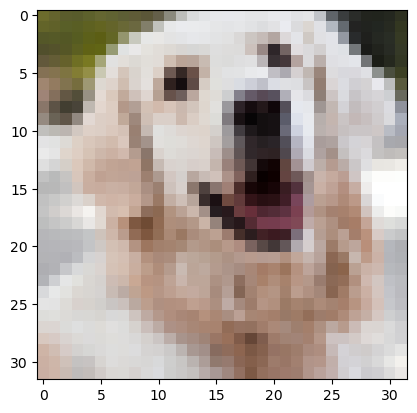

In [3]:
dog_img = Image.open("dog.jpg")
rescaled_img = dog_img.crop((1500,1000,4500,4000)).resize((32,32))
img = np.array(rescaled_img)
pltimg = plt.imshow(img, cmap="gray")

## The convolution kernel 
We define the following kernel:

In [4]:
kernel_array = np.expand_dims(np.array([[0,-1,0], [-1, 4 , -1], [0, -1, 0]]), -1).repeat( 3, axis=-1)

## The convolution module

Let start with an example using the library defined at the top of the notebook. If all necessary operation to implement the convolution, using our library with basics operations will leads to computational error (python does not realy like recursion).


**Question 1:** Create a function convolution with two loops that will performs the convolution of an image (**img**) with a kernel (**kernel**) given in parameters. You should use up to 2 loops (visit all pixels of the input image) and apply the convolution. Notice that we consider the mean pooling approach. We will not consider stride at first and only one channel for the output.

In [5]:
def convolution_with_loop_and_init_lib(img, kernel):
    iwidth, iheight, ichannel = img.shape
    kwidth, kheight, kchannel = kernel.shape

    out_width = iwidth - kwidth + 1
    out_height = iheight - kheight + 1

    output = ComputationGraphNode(np.zeros((out_width, out_height)))

    return output

In [ ]:
kernel = Parameter(kernel_array, 'kernel')
input = ComputationGraphNode(img/256.)
convolued_image = convolution_with_loop(input, kernel, stride=1)
fig = plt.imshow(convolued_image.value/convolued_image.value.max(), cmap='gray')
convolued_image.mean().backward()


**Question 2:** What happens when we increase the size of the image? Why? What is the solution? (enginering question)

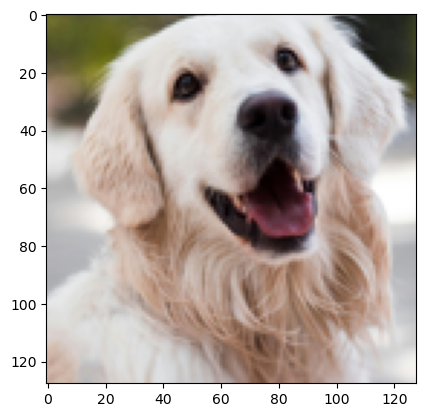

In [7]:
rescaled_img = dog_img.crop((1500,1000,4500,4000)).resize((128,128))
img = np.array(rescaled_img)
pltimg = plt.imshow(img, cmap="gray")

**Question 3:** Implement the forward of the convolution operator, for different stride, padding and different channels as output (using loop). All parameters here will be numpy array, you can use loop

In [8]:
def Conv2D(input_data, kernel, bias_node, stride=1, padding=1):
    """
    Convolution 2D operation
    """
    input_data = input_data.value
    kernel = kernel.value
    bias = bias_node.value
    in_channel, in_height, in_width = input_data.shape
    out_channel, kernel_height, kernel_width = kernel.shape
    out_height = (in_height - kernel_height + 2 * padding) // stride + 1
    out_width = (in_width - kernel_width + 2 * padding) // stride + 1
    output = np.zeros((out_channel, out_height, out_width))
    for i in range(out_height):
        for j in range(out_width):
            for c in range(out_channel):
                for k in range(in_channel):
                    for ki in range(kernel_height):
                        for kj in range(kernel_width):
                            output[c, i, j] += input_data[k, i + ki, j + kj] * kernel[c, ki, kj]
                output[c, i, j] += bias[c]
    return ComputationGraphNode(output)
    raise NotImplementedError()


**Question 4:** Try different kernel and plot the different output 

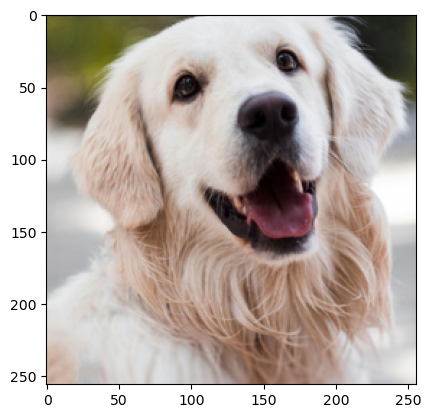

In [10]:
dog_img = Image.open("dog.jpg")
rescaled_img = dog_img.crop((1500,1000,4500,4000)).resize((256,256))
img = np.array(rescaled_img)/256.
pltimg = plt.imshow(img, cmap="gray")
# raise NotImplementedError()

**Question 5:** (Bonus) Implement the forward and backward operation (but go to the next lab exercise first)


**NB:** The backward for both weights and input are also convolutions (if no stride classic convolution else dilated convolution)

In [ ]:
class Convolution2DLoop(Operation):
    @staticmethod
    def forward(input_node, kernels_node, bias_node, stride=1, padding=1):
        pass

    @staticmethod
    def backward(input_node, kernels_node, bias_node, stride, padding, output_gradient):
        pass